In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from mapping import map_str_values
from sklearn import metrics


## Data

In [53]:
X = pd.read_csv("data/train_values.csv", index_col="building_id")
Y = pd.read_csv("data/train_labels.csv", index_col="building_id") - 1
# X = map_str_values(X)

## Áp dụng one hot encode cho các biến phân loại 

In [54]:
X = pd.get_dummies(X, dtype=int)
X.dtypes

geo_level_1_id              int64
geo_level_2_id              int64
geo_level_3_id              int64
count_floors_pre_eq         int64
age                         int64
                            ...  
plan_configuration_u        int32
legal_ownership_status_a    int32
legal_ownership_status_r    int32
legal_ownership_status_v    int32
legal_ownership_status_w    int32
Length: 68, dtype: object

## Chia train, test

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=192)
X_train.shape

(195450, 68)

In [56]:
continuous_cols = np.array(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families'])

binary_cols = X_train[X_train.columns.difference(continuous_cols)].columns.to_numpy()

continuous_idxs = np.sort(X_train.columns.get_indexer(continuous_cols))
binary_idxs = np.sort(X_train.columns.get_indexer(binary_cols))

binary_idxs

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67], dtype=int64)

---

## Model MixedNB kết hợp giữa GaussianNB và BernouliNB (Tự code)

- Vì một bộ data có thể chứa rất nhiều loại dữ liệu, cụ thể với bộ dữ liệu động đất nepal có 3 loại: (continuous, categorical, binary)
- Chúng ta có thể convert dữ liệu categorical và binary về cùng một loại => Quyết định convert categorical về binary sử dụng one hot encode

   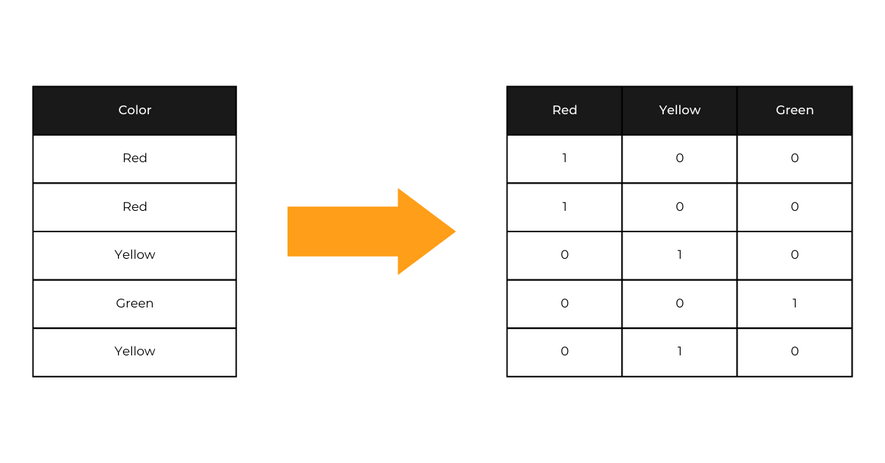

=> Dữ liệu chỉ còn 2 loại continuous và binary, chúng ta có thể sử dụng 2 mô hình GaussianNB và BernouliNB

- Ý tưởng: Xác định các feature nào là continuous, feature nào là binary và tính toán các xác xuất của feature với loại dữ liệu tương ứng (Giải thích ở file naive_bayes.ipynb)

In [57]:
class MixedNB():
    def __init__(self, gauss_index=None, bernouli_index=None):
        self.gauss_index = gauss_index # Index để tính xs của gauss
        self.bernouli_index = bernouli_index # Index để tính xs của bernouli


    def fit(self, X, Y): # Lưu trữ, tính toán những tham số cần thiết cho 2 mô hình gaussianNB và bernouliNB
        self.classes = np.unique(np.array(Y))
        self.n_features = X.shape[1]
        n_class = len(self.classes)
        self.class_priors = np.empty(shape=(n_class))

        self._calculate_stuffs(X, Y)

    def _calculate_stuffs(self, X, Y): # Tính toán means, vars, các P(i|c)  
        P_ic = []
        means = []
        vars_ = []

        for k, c in enumerate(self.classes): # Lặp qua tất cả các class
            Xc = X.iloc[np.where(Y == c)] # Lấy ra các X có cùng class
            temp = [] # Mảng lưu trữ các xs P(i|C) của class c
            temp_mean = [] # Mảng lưu trữ các mean của class c 
            temp_var = [] # Mảng lưu trữ các var của class c
            self.class_priors[k] = (len(Xc)) / (len(X)) # Tính toán xs prior của class c
            
            for i in range(X.shape[1]): # Lặp qua tất cả các feature của các record có cùng class c
                feat_probs_c = np.sum(Xc.iloc[:, i]) / len(Xc)

                temp.append(feat_probs_c)
                temp_mean.append(np.mean(Xc.iloc[:, i]))
                temp_var.append(np.var(Xc.iloc[:, i]))

            P_ic.append(temp)
            means.append(temp_mean)
            vars_.append(temp_var)

        # Lưu trữ các ma trận xs, means, vars của tất cả các class
        self.P_ic = np.array(P_ic)
        self.means = np.array(means)
        self.vars = np.array(vars_)


    def _pdf_binomial(self, x, feat_probs_class): # Hàm pdf của pp nhị thức
        return (feat_probs_class ** x) * ((1 - feat_probs_class) ** (1 - x))
    

    def _pdf_gauss(self, x, mean, variance): # Hàm pdf của pp gauss
        exponent = np.exp(-((x - mean) ** 2) / (2 * variance))
        return (1 / np.sqrt(2 * np.pi * variance)) * exponent
    
    
    def _get_joint_probs(self, X): # Tính toán các xs posteriors

        class_probs = [] 
        for x in X:
            # print(x)
            posts = []

            for i in range(len(self.class_priors)):
                post = np.log(self.class_priors[i]) # Lấy ra xs priors ứng với class thứ i

                for j in range(X.shape[1]): # Xét theo index truyền vào để quyết định xem tính toán với pdf nào
        
                    if j in self.gauss_index:
                        post += np.log(self._pdf_gauss(x=x[j], mean=self.means[i,j], variance=self.vars[i, j]))
                    elif j in self.bernouli_index:
        
                        post += np.log(self._pdf_binomial(x=x[j], feat_probs_class=self.P_ic[i, j]))

                posts.append(post)
            class_probs.append(posts)

        return np.array(class_probs)
    
    
    def predict(self, X):
        probs = self._get_joint_probs(X)
        # print(probs)
        Y_preds = []
        for prob in probs: # Lặp qua tất cả các xs posteriors
            Y_preds.append(self.classes[np.argmax(prob)]) # Lấy index của xs max => Phân loại

        return np.array(Y_preds)



- Do bộ data có nhiều loại dữ liệu, cụ thể là feature từ (0-6) là liên tục, feature (7-n) là binary (Do đã áp dụng one hot encode) nên chúng ta có thể truyền dữ liệu index dưới dạng range

In [58]:
mixNB = MixedNB(continuous_idxs, binary_idxs)
mixNB.fit(X_train, Y_train["damage_grade"])


In [59]:
preds = mixNB.predict(X_test.to_numpy())
preds.shape

C:\Users\Admin\AppData\Local\Temp\ipykernel_1636\402989197.py:69: RuntimeWarning: divide by zero encountered in log
  post += np.log(self._pdf_binomial(x=x[j], feat_probs_class=self.P_ic[i, j]))


(65151,)

- Do code chưa tối ưu về thuật toán nên thời gian chạy khá lâu (20 - 30s) nhưng độ chính xác cũng không quá kém với những mô hình NB khác 

In [84]:
print(metrics.classification_report(Y_test, preds, digits=4))

              precision    recall  f1-score   support

           0     0.4128    0.5696    0.4787      6275
           1     0.6446    0.3792    0.4775     37165
           2     0.4262    0.6797    0.5239     21711

    accuracy                         0.4977     65151
   macro avg     0.4945    0.5428    0.4934     65151
weighted avg     0.5495    0.4977    0.4931     65151



[[ 3574  1536  1165]
 [ 4367 14094 18704]
 [  717  6236 14758]]


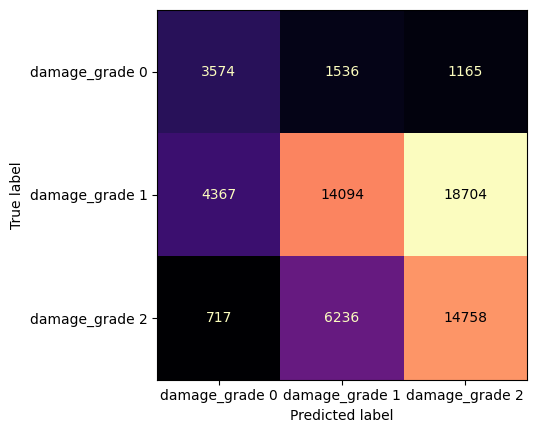

In [61]:
cm = metrics.confusion_matrix(Y_test, preds)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot(cmap="magma", colorbar=False)
print(cm)

---

## Dùng kết hợp 2 thư viện GaussianNB và BernoulliNB để tạo thành mô hình mới

In [76]:
class MixedNB2():
    def __init__(self, continuous_idx, binary_idx):
        self.continuous_idx = continuous_idx
        self.binary_idx = binary_idx

        self.gaussNB = GaussianNB()
        self.berNB = BernoulliNB()

    def fit(self, X, Y): # fit cả 2 model theo index truyền vào
        self.gaussNB.fit(X.iloc[:,self.continuous_idx], Y)
        self.berNB.fit(X.iloc[:, self.binary_idx], Y)

    def predict(self, X):
        y_pred = np.empty(X.shape[0])
        pred_probs_gauss = self.gaussNB.predict_joint_log_proba(X.iloc[:,self.continuous_idx]) # Lấy ra log(P(X|c)) ứng với mỗi xi trong X_test truyền vào (trong khoảng continuous_idx)
        pred_probs_bern = self.berNB.predict_joint_log_proba(X.iloc[:, self.binary_idx]) # Lấy ra log(P(X|c)) ứng với mỗi xi trong X_test truyền vào (trong khoảng binary_idx)
        log_posts = pred_probs_gauss + pred_probs_bern # Tính log(P(y|c)) 

        for i in range(len(log_posts)):
            y_pred[i] = np.argmax(log_posts[i])

        return np.array(y_pred, dtype=int)
        

In [77]:
mNB2 = MixedNB2(continuous_idxs, binary_idxs)
mNB2.fit(X_train, Y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [78]:
Y_preds = mNB2.predict(X_test)
Y_preds

array([0, 1, 1, ..., 2, 0, 0])

In [83]:
print(metrics.classification_report(Y_test, Y_preds, digits=4))

              precision    recall  f1-score   support

           0     0.4360    0.5061    0.4685      6275
           1     0.6233    0.6653    0.6436     37165
           2     0.4874    0.4085    0.4444     21711

    accuracy                         0.5644     65151
   macro avg     0.5156    0.5266    0.5188     65151
weighted avg     0.5600    0.5644    0.5604     65151



[[ 3176  2628   471]
 [ 3581 24727  8857]
 [  527 12316  8868]]


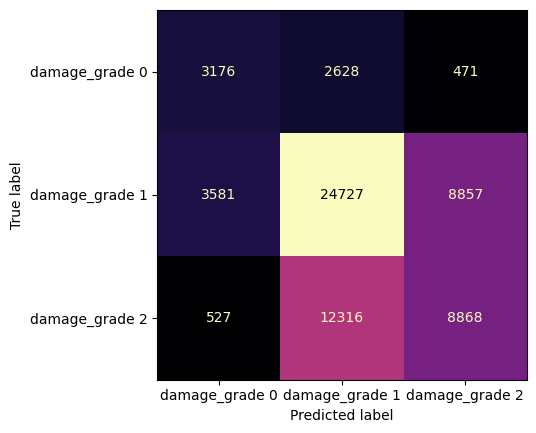

In [66]:
cm = metrics.confusion_matrix(Y_test, Y_preds)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot(cmap="magma", colorbar=False)
print(cm)